In [8]:
import natgas_price_scpt as ngps

In [9]:
print("Starting analysis...")

# Load the data
data = ngps.load_data('Nat_Gas.csv')
print("Data loaded successfully!")

Starting analysis...
Data loaded successfully!


/home/walter/Documents/JPMorgan_Chase/Quantitative Research/Task 1/natgas_price_scpt.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Dates'] = pd.to_datetime(data['Dates'])


Prices plot saved as 'historical_prices.png'!
Prices plotted!


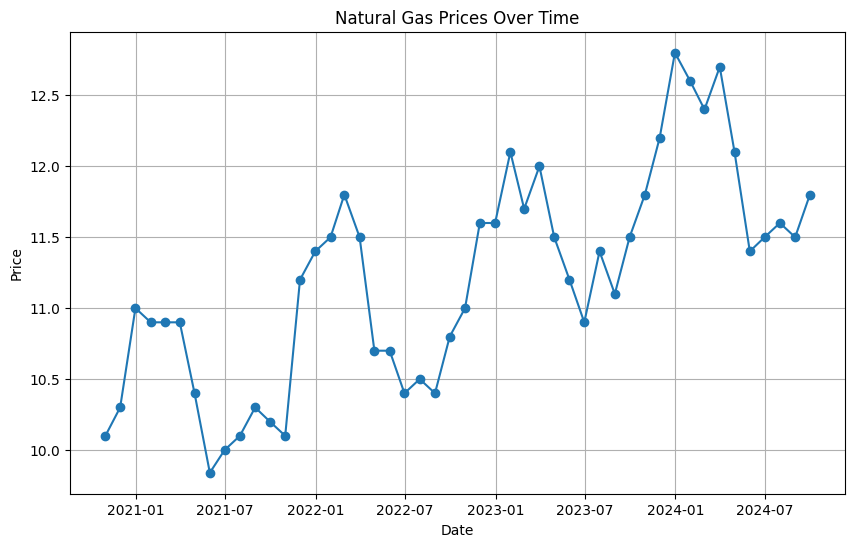

In [10]:
# Plot historical prices
ngps.plot_prices(data)
print("Prices plotted!")

Seasonality plot saved as 'seasonality.png'!
Seasonality analyzed!


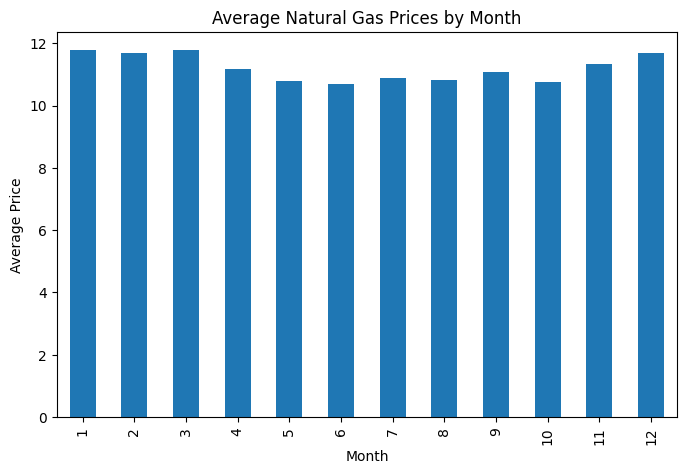

In [11]:
# Analyze seasonality
ngps.analyze_seasonality(data)
print("Seasonality analyzed!")



/home/walter/Documents/JPMorgan_Chase/Quantitative Research/Task 1/natgas_price_scpt.py:65: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(data['Dates'].max() + pd.DateOffset(months=1), periods=months, freq='M')


Extrapolated prices plot saved as 'extrapolated_prices.png'!
Future prices extrapolated!


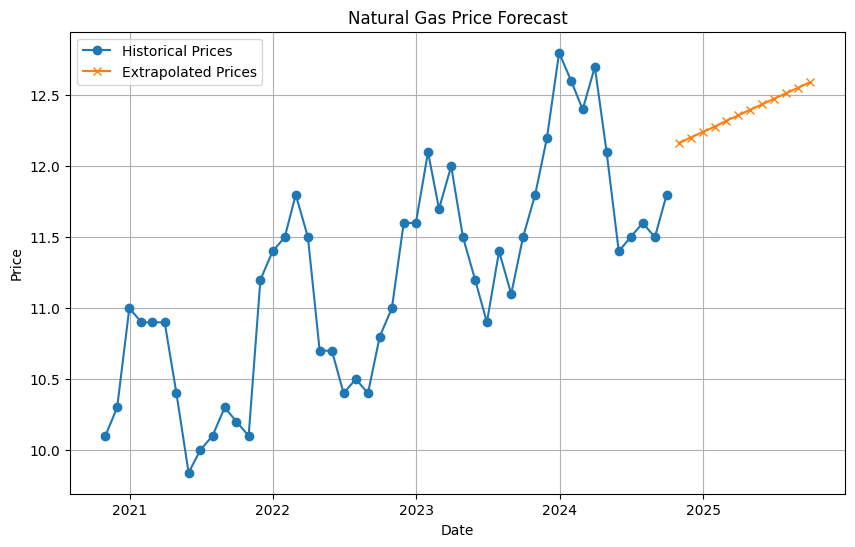

In [12]:
# Extrapolate future prices
future_data = ngps.extrapolate_future_prices(data)
print("Future prices extrapolated!")



In [13]:
# Estimate price for a specific date
estimated_price = ngps.estimate_price(data, '2022-05-15')
print(f"Estimated price for 2022-05-15: {estimated_price:.2f}")

Estimated price for 2022-05-15: 10.70


# Model Solution:

In [14]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import date, timedelta


In [15]:
# Read the CSV file
df = pd.read_csv('Nat_Gas.csv', parse_dates=['Dates'])

# Extract prices and dates
prices = df['Prices'].values
dates = df['Dates'].values


/tmp/ipykernel_111974/854284746.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('Nat_Gas.csv', parse_dates=['Dates'])


/tmp/ipykernel_111974/1429578174.py:3: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  ax.plot_date(dates, prices, '-')


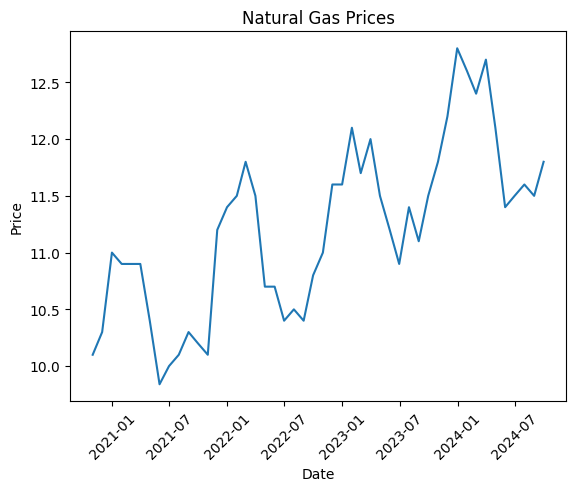

In [16]:
# Plot prices against dates
fig, ax = plt.subplots()
ax.plot_date(dates, prices, '-')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Natural Gas Prices')
ax.tick_params(axis='x', rotation=45)

plt.show()


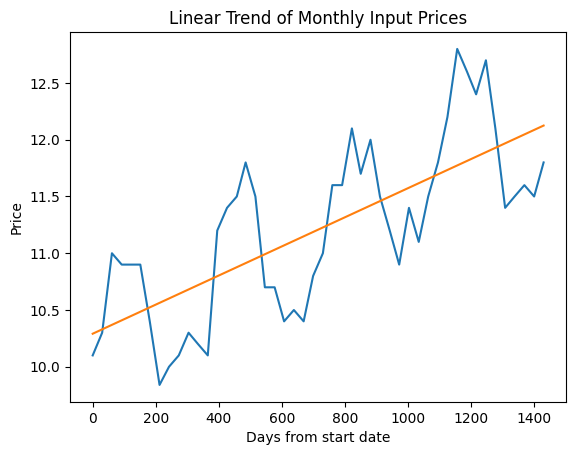

Slope: 0.001282373598760221 Intercept: 10.29104112595228


In [17]:
# Start and end dates for the interpolation range
start_date = date(2020, 10, 31)
end_date = date(2024, 9, 30)

# Generate monthly dates from start to end
months = []
year = start_date.year
month = start_date.month + 1
while True:
    current = date(year, month, 1) + timedelta(days=-1)
    months.append(current)
    if current.month == end_date.month and current.year == end_date.year:
        break
    else:
        month = ((month + 1) % 12) or 12
        if month == 1:
            year += 1

# Convert the dates to days from the start
days_from_start = [(day - start_date).days for day in months]

# Linear regression function
def simple_regression(x, y):
    xbar = np.mean(x)
    ybar = np.mean(y)
    slope = np.sum((x - xbar) * (y - ybar)) / np.sum((x - xbar) ** 2)
    intercept = ybar - slope * xbar
    return slope, intercept

# Perform regression
time = np.array(days_from_start)
slope, intercept = simple_regression(time, prices)

# Plot the linear trend
plt.plot(time, prices)
plt.plot(time, time * slope + intercept)
plt.xlabel('Days from start date')
plt.ylabel('Price')
plt.title('Linear Trend of Monthly Input Prices')
plt.show()

# Display slope and intercept
print("Slope:", slope, "Intercept:", intercept)


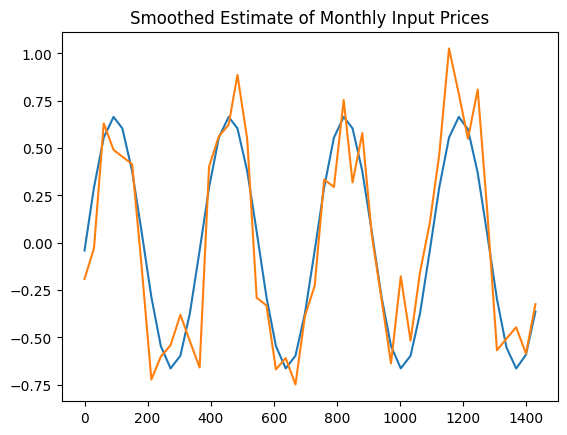

In [18]:
# Remove the trend from the prices
sin_prices = prices - (time * slope + intercept)

# Calculate sin and cos components
sin_time = np.sin(time * 2 * np.pi / 365)
cos_time = np.cos(time * 2 * np.pi / 365)

# Bilinear regression function
def bilinear_regression(y, x1, x2):
    slope1 = np.sum(y * x1) / np.sum(x1 ** 2)
    slope2 = np.sum(y * x2) / np.sum(x2 ** 2)
    return slope1, slope2

# Perform bilinear regression
slope1, slope2 = bilinear_regression(sin_prices, sin_time, cos_time)

# Calculate amplitude and phase shift
amplitude = np.sqrt(slope1 ** 2 + slope2 ** 2)
shift = np.arctan2(slope2, slope1)

# Plot smoothed estimate of full dataset
plt.plot(time, amplitude * np.sin(time * 2 * np.pi / 365 + shift))
plt.plot(time, sin_prices)
plt.title('Smoothed Estimate of Monthly Input Prices')
plt.show()


In [19]:
# Define the interpolation function
def interpolate(date):
    days = (date - pd.Timestamp(start_date)).days
    if days in days_from_start:
        return prices[days_from_start.index(days)]
    else:
        return amplitude * np.sin(days * 2 * np.pi / 365 + shift) + days * slope + intercept


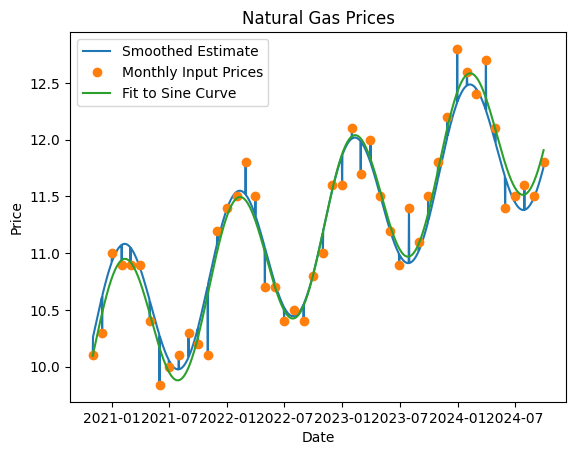

In [20]:
# Create a range of continuous dates
continuous_dates = pd.date_range(start=pd.Timestamp(start_date), end=pd.Timestamp(end_date), freq='D')

# Plot the smoothed estimate using interpolation
plt.plot(continuous_dates, [interpolate(date) for date in continuous_dates], label='Smoothed Estimate')

# Fit the monthly input prices to the sine curve
x = np.array(days_from_start)<class 'numpy.float64'>
10.7
fit_slope, fit_intercept = simple_regression(x, y - fit_amplitude * np.sin(x * 2 * np.pi / 365 + fit_shift))

plt.plot(dates, y, 'o', label='Monthly Input Prices')
plt.plot(continuous_dates, fit_amplitude * np.sin((continuous_dates - pd.Timestamp(start_date)).days * 2 * np.pi / 365 + fit_shift) + (continuous_dates - pd.Timestamp(start_date)).days * fit_slope + fit_intercept, label='Fit to Sine Curve')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Natural Gas Prices')
plt.legend()
plt.show()


In [21]:
# Define the future date for which you want to estimate the price
future_date = pd.Timestamp('2022-05-15')

# Use the interpolate function to estimate the price for this future date
estimated_price = interpolate(future_date)

# Print the estimated price for the given date
print(f"Estimated price for {future_date.date()}: {estimated_price}")


Estimated price for 2022-05-15: 10.897707024487152
